# 3.2 DataLoaderの作成

- 本ファイルでは、PSPNetなどセマンティックセグメンテーション用のDatasetとDataLoaderを作成します。VOC2012データセットを対象とします。


In [3]:
!git clone https://github.com/HisakaKoji/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 487 (delta 22), reused 0 (delta 0), pack-reused 443
Receiving objects: 100% (487/487), 17.40 MiB | 6.70 MiB/s, done.
Resolving deltas: 100% (257/257), done.


In [4]:
%cd pytorch_advanced/3_semantic_segmentation/

/content/pytorch_advanced/3_semantic_segmentation


In [0]:
import os
import urllib.request
import zipfile
import tarfile

In [0]:
# フォルダ「data」が存在しない場合は作成する
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [0]:
# VOC2012のデータセットをここからダウンロードします
# 時間がかかります（約15分）
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tarファイルを読み込み
    tar.extractall(data_dir)  # tarを解凍
    tar.close()  # tarファイルをクローズ

In [0]:
# フォルダ「weights」が存在しない場合は作成する
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

# フォルダ「weights」にネットワークの初期値として使用する「pspnet50_ADE20K.pth」を
# 筆者のGoogle Driveから手動でダウンロードする
    
https://drive.google.com/open?id=12eN6SpnawYuQmD1k9VgVW3QSgPR6hIC

【※（実施済み）】
乗馬の画像を手動でダウンロード

https://pixabay.com/ja/photos/%E3%82%AB%E3%82%A6%E3%83%9C%E3%83%BC%E3%82%A4-%E9%A6%AC-%E4%B9%97%E9%A6%AC-%E6%B0%B4-%E6%B5%B7-757575/
の640×426サイズの画像
（画像権利情報：商用利用無料、帰属表示は必要ありません）

を、フォルダ「data」の直下に置く。


本章の内容で筆者が作成した学習済みのPSPNetモデル「pspnet50_30.pth」

https://drive.google.com/open?id=192JenT9UTHjFb6fhwSdRgOWr8_RmDl4I
    
必ずしもダウンロードの必要はありませんが、
自分でPSPNetを学習させる前に、学習済みモデルをさわりたい場合は、
手動でダウンロードした「pspnet50_30.pth」をフォルダ「wights」に配置してください。

# 学習目標

1.	セマンティックセグメンテーションで使用するDatasetクラス、DataLoaderクラスを作成できるようになる
2.	PSPNetの前処理およびデータオーギュメンテーションの処理内容を理解する

# 事前準備

- 書籍の指示に従い、本章で使用するデータをダウンロードします。


In [0]:
# パッケージのimport
import os.path as osp
from PIL import Image

import torch.utils.data as data

# 画像データ、アノテーションデータへのファイルパスのリストを作成

In [0]:

def make_datapath_list(rootpath):
    """
    学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。

    Parameters
    ----------
    rootpath : str
        データフォルダへのパス

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        データへのパスを格納したリスト
    """

    # 画像ファイルとアノテーションファイルへのパスのテンプレートを作成
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 訓練と検証、それぞれのファイルのID（ファイル名）を取得する
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 訓練データの画像ファイルとアノテーションファイルへのパスリストを作成
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 検証データの画像ファイルとアノテーションファイルへのパスリストを作成
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 空白スペースと改行を除去
        img_path = (imgpath_template % file_id)  # 画像のパス
        anno_path = (annopath_template % file_id)  # アノテーションのパス
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [10]:
# 動作確認 ファイルパスのリストを取得
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])


./data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass/2007_000032.png


# Datasetの作成

In [0]:
# データ処理のクラスとデータオーギュメンテーションのクラスをimportする
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor


class DataTransform():
    """
    画像とアノテーションの前処理クラス。訓練時と検証時で異なる動作をする。
    画像のサイズをinput_size x input_sizeにする。
    訓練時はデータオーギュメンテーションする。


    Attributes
    ----------
    input_size : int
        リサイズ先の画像の大きさ。
    color_mean : (R, G, B)
        各色チャネルの平均値。
    color_std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 画像の拡大
                RandomRotation(angle=[-10, 10]),  # 回転
                RandomMirror(),  # ランダムミラー
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ]),
            'val': Compose([
                Resize(input_size),  # リサイズ(input_size)
                Normalize_Tensor(color_mean, color_std)  # 色情報の標準化とテンソル化
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img, anno_class_img)


In [0]:
class VOCDataset(data.Dataset):
    """
    VOC2012のDatasetを作成するクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    img_list : リスト
        画像のパスを格納したリスト
    anno_list : リスト
        アノテーションへのパスを格納したリスト
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    transform : object
        前処理クラスのインスタンス
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとアノテーションを取得
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''画像のTensor形式のデータ、アノテーションを取得する'''

        # 1. 画像読み込み
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [高さ][幅][色RGB]

        # 2. アノテーション画像読み込み
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [高さ][幅]

        # 3. 前処理を実施
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img


In [13]:
# 動作確認

# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# データセット作成
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# データの取り出し例
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))


torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.1872,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.1872,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.1872,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3431,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3431,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3431,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.08

# DataLoaderを作成

In [14]:
# データローダーの作成

batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作の確認
batch_iterator = iter(dataloaders_dict["val"])  # イタレータに変換
imges, anno_class_imges = next(batch_iterator)  # 1番目の要素を取り出す
print(imges.size())  # torch.Size([8, 3, 300, 300])
print(anno_class_imges.size())  # torch.Size([8, 3, 300, 300])


torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


以上

# （付録）Datasetから画像を取り出し、描画する

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## 訓練画像の描画

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


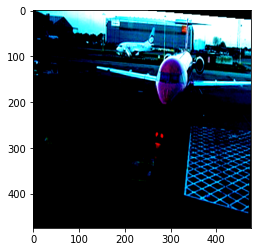

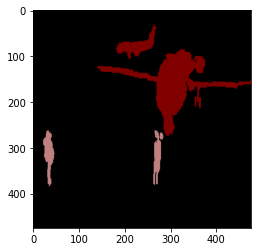

In [16]:
# 実行するたびに変わります

# 画像データの読み込み
index = 0
imges, anno_class_imges = train_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


## 検証画像の描画

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


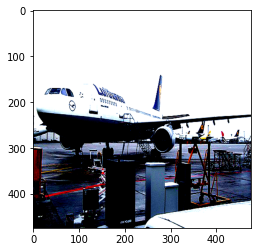

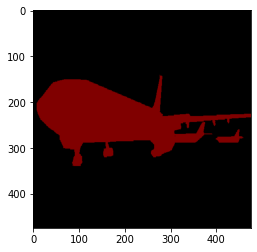

In [17]:
# 画像データの読み込み
index = 0
imges, anno_class_imges = val_dataset.__getitem__(index)

# 画像の表示
img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
plt.imshow(img_val)
plt.show()

# アノテーション画像の表示
anno_file_path = train_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()

anno_class_img_val = anno_class_imges.numpy()
anno_class_img_val = Image.fromarray(np.uint8(anno_class_img_val), mode="P")
anno_class_img_val.putpalette(p_palette)
plt.imshow(anno_class_img_val)
plt.show()


以上


## 3.3～3.6 ネットワークモデルの作成 **太字**
本ファイルでは、PSPNetのネットワークモデルと順伝搬forward関数を作成します。

# 3.3 学習目標

PSPNetのネットワーク構造をモジュール単位で理解する

PSPNetを構成する各モジュールの役割を理解する

PSPNetのネットワーククラスの実装を理解する

# 3.4 学習目標

Featureモジュールのサブネットワーク構成を理解する

サブネットワークFeatureMap_convolution を実装できるようになる

Residual Blockを理解する

Dilated Convolutionを理解する

サブネットワークbottleNeckPSPとbottleNeckIdentifyPSPを実装できるようになる

Featureモジュールを実装できるようになる

# 3.5 学習目標

Pyramid Poolingモジュールのサブネットワーク構成を理解する

Pyramid Poolingモジュールのマルチスケール処理の実現方法を理解する

Pyramid Poolingモジュールを実装できるようになる

# 3.6 学習目標

Decoderモジュールのサブネットワーク構成を理解する

Decoder モジュールを実装できるようになる

AuxLossモジュールのサブネットワーク構成を理解する

AuxLossモジュールを実装できるようになる

In [0]:
# パッケージのimport
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        # パラメータ設定
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_sizeの1/8に

        # 4つのモジュールを構成するサブネットワークの用意
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Featureモジュールの途中をAuxモジュールへ

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)

In [0]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase設定で入力を保存せずに出力を計算し、メモリ削減する

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs

In [0]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''構成するネットワークを用意'''
        super(FeatureMap_convolution, self).__init__()

        # 畳み込み層1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 畳み込み層3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # MaxPooling層
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs

In [0]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSPの用意
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSPの繰り返しの用意
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )

In [0]:

class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs

In [0]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # スキップ結合
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)

In [0]:
class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)

In [0]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        # 各畳み込み層の出力チャネル数
        out_channels = int(in_channels / len(pool_sizes))

        # 各畳み込み層を作成
        # この実装方法は愚直すぎてfor文で書きたいところですが、分かりやすさを優先しています
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 最終的に結合させる、dim=1でチャネル数の次元で結合
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output

In [0]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [0]:
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forwardで使用する画像サイズ
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [65]:

# モデルの定義
net = PSPNet(n_classes=21)
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNec

In [66]:
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)

# 計算
outputs = net(dummy_img)
print(outputs)

(tensor([[[[-1.9605e-01, -1.7186e-01, -1.4767e-01,  ..., -1.0659e-01,
           -5.8237e-02, -9.8875e-03],
          [-2.2200e-01, -1.9930e-01, -1.7660e-01,  ..., -9.8215e-02,
           -5.7610e-02, -1.7006e-02],
          [-2.4795e-01, -2.2674e-01, -2.0553e-01,  ..., -8.9844e-02,
           -5.6984e-02, -2.4124e-02],
          ...,
          [-5.9282e-02, -8.2195e-02, -1.0511e-01,  ..., -5.1955e-01,
           -5.5574e-01, -5.9192e-01],
          [-2.7919e-02, -5.9686e-02, -9.1453e-02,  ..., -5.2994e-01,
           -5.6689e-01, -6.0384e-01],
          [ 3.4438e-03, -3.7177e-02, -7.7798e-02,  ..., -5.4033e-01,
           -5.7804e-01, -6.1576e-01]],

         [[-5.4199e-01, -5.2634e-01, -5.1069e-01,  ..., -3.8975e-01,
           -4.1815e-01, -4.4654e-01],
          [-4.9854e-01, -4.9048e-01, -4.8243e-01,  ..., -3.7781e-01,
           -3.9995e-01, -4.2209e-01],
          [-4.5509e-01, -4.5463e-01, -4.5417e-01,  ..., -3.6588e-01,
           -3.8176e-01, -3.9764e-01],
          ...,
    


# 3.7 学習と検証の実施
本ファイルでは、PSPNetの学習と検証の実施を行います。AWSのGPUマシンで計算します。
p2.xlargeで約12時間かかります。
# 学習目標
PSPNetの学習と検証を実装できるようになる
セマンティックセグメンテーションのファインチューニングを理解する
事前準備
本書に従い学習済みモデルのファイル「pspnet50_ADE20K.pth」をダウンロードし、フォルダ「weights」に用意します。

In [0]:
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# 初期設定
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [0]:
from utils.dataloader import make_datapath_list, DataTransform, VOCDataset

# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader作成
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

In [71]:
from utils.pspnet import PSPNet

# ファインチューニングでPSPNetを作成
# ADE20Kデータセットの学習済みモデルを使用、ADE20Kはクラス数が150です
net = PSPNet(n_classes=150)

# ADE20K学習済みパラメータをロード
state_dict = torch.load("./weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)

# 分類用の畳み込み層を、出力数21のものにつけかえる
n_classes = 21
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

# 付け替えた畳み込み層を初期化する。活性化関数がシグモイド関数なのでXavierを使用する。


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)


print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


In [0]:
# 損失関数の設定
class PSPLoss(nn.Module):
    """PSPNetの損失関数のクラスです。"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_lossの重み

    def forward(self, outputs, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        outputs : PSPNetの出力(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 4755]
            正解のアノテーション情報

        Returns
        -------
        loss : テンソル
            損失の値
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss+self.aux_weight*loss_aux


criterion = PSPLoss(aux_weight=0.4)

In [0]:
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)


# スケジューラーの設定
def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1-epoch/max_epoch), 0.9)


scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [0]:
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                scheduler.step()  # 最適化schedulerの更新
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は5回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
                if imges.size()[0] == 1:
                    continue

                # GPUが使えるならGPUにデータを送る
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
                # multiple minibatchでのパラメータの更新
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(
                        outputs, anno_class_imges.long()) / batch_multiplier

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算
                        count -= 1  # multiple minibatch

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

    # 最後のネットワークを保存する
    torch.save(net.state_dict(), 'weights/pspnet50_' +
               str(epoch+1) + '.pth')

In [75]:

# 学習・検証を実行する
# google colabでは、 メモリーエラーになる。
# モデルダウンロードが必要。
num_epochs = 3
train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0


RuntimeError: ignored


# 3.8 推論の実施
本ファイルでは、学習させたPSPNetでセマンティックセグメンテーションを行います。
# 学習目標
# セマンティックセグメンテーションの推論を実装できるようになる
事前準備
学習させた重みパラメータ「pspnet50_30.pth」をフォルダ「weights」に用意する。

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [0]:
from utils.dataloader import make_datapath_list, DataTransform


# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 後ほどアノテーション画像のみを使用する

In [0]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load("./weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

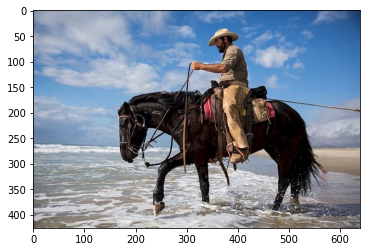

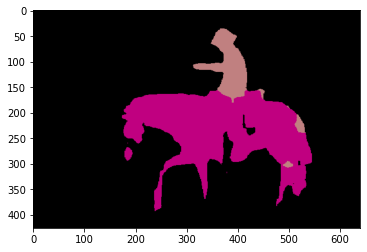

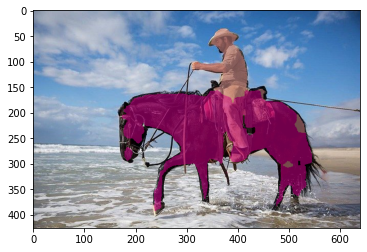

In [80]:
# 1. 元画像の表示
image_file_path = "./data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)


# 4. PSPNetで推論する
net.eval()
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])


# 5. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()


# 6. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 150は透過度の大きさを指定している

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()


# 3.8 推論の実施
本ファイルでは、学習させたPSPNetでセマンティックセグメンテーションを行います。
# 学習目標
セマンティックセグメンテーションの推論を実装できるようになる
# 事前準備
学習させた重みパラメータ「pspnet50_30.pth」をフォルダ「weights」に用意する。

In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [0]:
from utils.dataloader import make_datapath_list, DataTransform, VOCDataset


# ファイルパスリスト作成
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset作成
# (RGB)の色の平均値と標準偏差
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

In [83]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load("./weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')

ネットワーク設定完了：学習済みの重みをロードしました


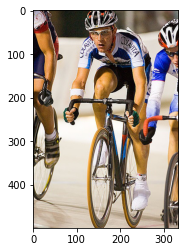

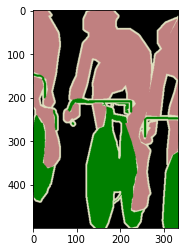

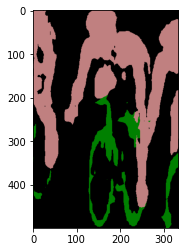

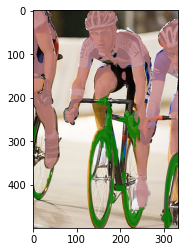

In [84]:
img_index = 4

# 1. 元画像の表示
image_file_path = val_img_list[img_index]
img_original = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img_original.size
plt.imshow(img_original)
plt.show()

# 2. 正解アノテーション画像の表示
anno_file_path = val_anno_list[img_index]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅][色RGB]
p_palette = anno_class_img.getpalette()
plt.imshow(anno_class_img)
plt.show()

# 3. PSPNetで推論する
net.eval()
img, anno_class_img = val_dataset.__getitem__(img_index)
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視

# 4. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 5. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 200))
            # 200は透過度の大きさを指定している

result = Image.alpha_composite(img_original.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()